In [1]:
import sys 
import os

In [2]:
src_path = os.path.abspath("../")
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from src.tools.md_class_functions import *
from src.tools.md_class_utility import*
from src.tools.md_class_graphs import *
from src.water_md_class import *

### Set path to your lammps file and initialise trajectory object

In [ ]:
# path towards an ion trajectory with recombination happening
water_path = "../testing/recombination_tester.lammpstrj"

In [ ]:
 #initialise trajectory object by passing path, format and scaling = 0 means not scaled -> will be scaled in __init__
trj = Trajectory(water_path, format="lammpstrj", scaled=0, verbosity="silent")

### Access class atributes of the Trajectory object 

In [ ]:
    # access class atributes which are calculated on initialisation, basic information about the trajectory 
    print("Trajectory first 3 rows")
    print(trj.trajectory[0, :3, :])
    print("box dimensions")
    print(trj.box_dim[0])
    print("box size")
    print(trj.box_size[0])
    print("number of atoms")
    print(trj.n_atoms)
    print("number of timesteps")
    print(trj.n_snapshots)
    print("species split")
    print("s1 = Hydrogen")
    print(trj.s1[0][:3, :])
    print("s2 = Oxygen")
    print(trj.s2[0][:3, :])
    print("did recombine?")
    print(trj.did_recombine)
    print("Recombination Time")
    print(trj.recombination_time)

### Class Methods


In [ ]:
#sets the self.distance attribute
trj.get_ion_distance()

In [ ]:
plot_ion_distance_euc(trj, (11, 6))

In [ ]:
#for further evaluations i just pick one timestep < recombination_time
time_step = 773

In [ ]:
bonding_list, unique_oxygens, ions = trj.get_hydrogen_bonds(timestep=time_step, cutoff=2.9, starting_oh=True)

In [ ]:
plot_hbonds_single(bonding_list, trj.s2[time_step], start="OH", fig_size=(10, 8))

In [ ]:
bonds_H3O, oxygens_H3O, ions =  trj.get_hydrogen_bonds(timestep=time_step, cutoff=2.9, starting_oh=False)
bonds_OH, oxygens_OH, _ =  trj.get_hydrogen_bonds(timestep=time_step, cutoff=2.9, starting_oh=True)

In [ ]:
plot_hbond_network(bonds_OH, bonds_H3O, trj.s2[time_step], ions, fig_size=(10, 8))

In [ ]:
# HB bonds for the entire trajectory
hb_timeseries = get_HB_timeseries(trj)

In [ ]:
# use %matplotlib widget or similar to make interactive
plot_HB_network(hb_timeseries, trj.s2, plot_oxygen=True)

In [ ]:
plot_HB_ratio(hb_timeseries, n_atoms=trj.n_atoms)

In [ ]:
wire_lengths, h_bonds = get_all_wires(trj)

In [ ]:
%matplotlib widget

In [ ]:
plot_HB_wire(h_bonds, trj, plot_hydrogens=True)

In [ ]:
plot_wire_length(wire_lengths)

In [ ]:
ts_bonds, mol_list, ion_ts = get_transition_cations(trj)

In [ ]:
plot_transition_cations(mol_list, ion_ts, trj)

In [ ]:
OO_rdf = trj.get_rdf_rdist(stop=8.0)

In [ ]:
OO_rdf

In [ ]:
HH_rdf = trj.get_rdf_rdist(gr_type="HH")

In [ ]:
plot_rdf(OO_rdf[0], OO_rdf[1])

In [ ]:
plot_rdf(HH_rdf[0], HH_rdf[1], type="HH")

In [ ]:
MSD = trj.get_MSD()

In [ ]:
plot_MSD(MSD)

In [ ]:
diff = trj.get_translational_diffusion(MSD)
diff

### Trajectory Manipulation




In [ ]:
#trjwater.lammpstrj is just a water sim trajectory without ions 
#note: (actually already has ions in it but they dont recombine still same concept)
path_water = "../testing/trjwater.lammpstrj"

In [ ]:
traj_2 = Trajectory(file=path_water, format="lammpstrj", scaled=1, verbosity="loud")

In [ ]:
# generate ion trajectories for ion MD runs
traj_2.get_displace(snapshot=50, distance=0.4, eps=0.05, path="../tutorial_notebook/", num_traj=2)

In [ ]:
#cut out trajectory at timestamp 50
traj_2.cut_snapshot(snapshot=50, path="../tutorial_notebook/")

In [ ]:
# remove 20 atoms from timestap 50
traj_2.remove_atoms(N=20, snap=50, format_out="lammps")

In [ ]:
# group together the molecules and writes it into a ovito readable lammpstrj file
traj_2.group_molecules(path="../tutorial_notebook/")

In [ ]:
data = np.loadtxt("C:\\Users\\Nutzer\\Documents\\GitHub\\MD_Lammps_analysis_class\\tutorial_notebook\\OH_ion_RDF_averaged.csv", delimiter=",")
plt.plot(data[1], data[0])

In [ ]:
data = np.loadtxt("C:\\Users\\Nutzer\\Documents\\GitHub\\MD_Lammps_analysis_class\\tutorial_notebook\\H3O_ion_RDF_averaged.csv", delimiter=",")
plt.plot(data[1], data[0])

In [10]:
h3o_ids_ts = np.empty((trj.recombination_time, ), dtype=int)
oh_ids_ts = np.empty((trj.recombination_time, ), dtype=int)
for ts in range(trj.recombination_time):
    
    OH_id = None
    H3O_id = None

    # note: find nearest O atom for each H atom
    indexlist_group, _ = trj.get_neighbour_KDT(species_1=trj.s1[ts],
                                                species_2=trj.s2[ts], mode="pbc", snapshot=ts)

    # note: find he  number of  occourence of O atoms for which it is the nearest to an H atom.
    # -> for H2O each O atom will count twice, for each H3O+ each O atom will count 3 times and so on.
    temp = [None] * trj.s2[ts].shape[0]
    for O_atom in range(trj.s2[ts].shape[0]):
        temp[O_atom] = np.append(np.argwhere(indexlist_group == O_atom), O_atom)

    # check how often each O atom counted -> molecules formation  OH- = 1 time H3O+  3 Times  H2O 2 times.
    for ind, _list in enumerate(temp):
        #if len(_list) == 2:
         #   OH_id = _list[-1]
        if len(_list) == 4:
            H3O_id = _list[-1]
            
    h3o_ids_ts[ts] = trj.s2[ts][H3O_id, 0]
    #oh_ids_ts[ts] = trj.s2[ts][OH_id, 0]


jumps = []
diffusion = []
for position_id in range(1, trj.recombination_time):
    if h3o_ids_ts[position_id-1] != h3o_ids_ts[position_id]:
        jumps.append(position_id-1)
    else:
        diffusion.append(position_id-1)
        
        

    


In [11]:
h3o_ids_ts

array([1447, 1447, 1447, ..., 1492, 1492, 1492])

In [12]:
jumps

[24,
 47,
 75,
 122,
 169,
 185,
 479,
 494,
 519,
 541,
 606,
 613,
 772,
 796,
 829,
 865,
 886,
 1477,
 1489,
 1521,
 1557,
 1663,
 1687,
 1719,
 1877,
 2124,
 2129,
 2278,
 2297,
 2325,
 2442,
 2877,
 2896,
 2924,
 2951,
 2991,
 3025,
 3041,
 3170,
 3425,
 3452,
 3575,
 3595,
 3674,
 3686,
 3701,
 4023,
 4047,
 4071,
 4218,
 4259,
 4275,
 4321,
 4330,
 4374,
 4508,
 4559,
 4614,
 4626,
 4723,
 4927,
 4946,
 4967,
 4991,
 5178,
 5197,
 5225,
 5262,
 5298,
 5326,
 5986,
 5996,
 6874,
 6883,
 7075,
 7090,
 7287,
 7293,
 7675,
 7686,
 7720,
 7728,
 8991,
 9010,
 9038,
 9041,
 9402,
 9450,
 9474,
 9580,
 9620,
 9654,
 10001,
 10023,
 10077,
 10220,
 10240,
 10803,
 10829,
 10863,
 10896,
 10931,
 10955,
 10984,
 11185,
 11197,
 11228,
 11242,
 11379,
 11396,
 11436,
 11606,
 11663,
 11688,
 11701,
 12379,
 12386,
 12699,
 12714,
 12737,
 12789,
 12806,
 12824,
 12882,
 12895,
 12985,
 13008,
 13061,
 13068,
 13100,
 13430,
 13434,
 13442,
 14075,
 14102,
 14264,
 14272,
 14398,
 14431,


In [13]:
diffusion

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 186,
 187,
 188,
 189,
 19

In [ ]:
def get_diffusion_distance(jumps: [int], diffusion: [int], ion_ids: [int], trj: Trajectory):
    
    coordinates = trj.s2
    temp = []
    diffusion_distances = []
    diffusion_coordinates = []

    previous = diffusion[0]
    intervalls = []
    _temp = []


    for diff_ts in range(1, len(diffusion)):
        #print(previous)
        if (diffusion[diff_ts] - 1 == previous): 
            _temp.append(previous)
            previous = diffusion[diff_ts]
        else:
            _temp.append(previous)
            if len(_temp) > 1:
                intervalls.append(_temp)
            _temp = []
            previous = diffusion[diff_ts]
    print(intervalls)
    for diffusion_int in intervalls:
        for diff in range(len(diffusion_int) -1):
            temp.append(get_distance(coordinates[diffusion_int[diff]][coordinates[diffusion_int[diff]][:, 0]==ion_ids[diffusion_int[diff]], 2:][0],
                                    coordinates[diffusion_int[diff+1]][coordinates[diffusion_int[diff+1]][:, 0]==ion_ids[diffusion_int[diff+1]], 2:][0],
                                    mode="pbc"))
        diffusion_distances.append(sum(temp))
        temp = []
    return diffusion_distances
        

In [ ]:
def get_jump_distances(jumps: [int], ion_ids: [int], trj: Trajectory):
    
    coordinates = trj.s2
    jump_distances = []
    
    for jump_ts in range(len(jumps)):
        jump_distances.append(get_distance(coordinates[jumps[jump_ts]][coordinates[jumps[jump_ts]][:, 0] == ion_ids[jumps[jump_ts]], 2:][0],
                                          coordinates[jumps[jump_ts]-1][coordinates[jumps[jump_ts]-1][:, 0] == ion_ids[jumps[jump_ts]-1], 2:][0],
                                          mode="pbc"))
        
    return jump_distances

In [ ]:
diff_dist = get_diffusion_distance(jumps, diffusion, h3o_ids_ts, trj)
jump_dist = get_jump_distances(jumps, h3o_ids_ts, trj)

In [ ]:
len(jump_dist)

In [ ]:
len(diff_dist)

In [ ]:
jump_dist

In [ ]:
import struct
print(struct.calcsize("P") * 8)

In [ ]:
path = "Z://cluster_runs//n_608//NN_charged_test//results//charged_system//charged_run_0//trjwater.lammpstrj"

In [ ]:
trj = Trajectory(file=path)

In [ ]:
trj.did_recombine

In [ ]:
diffusion, jumps, h3_ids_ts = diffusion_timestep_tracing(trj)

In [ ]:
diff_dist = get_diffusion_distance(diffusion, h3_ids_ts, trj)

In [ ]:
jump_dist = get_jump_distances(jumps, h3_ids_ts, trj)

In [ ]:
len(jump_dist)

In [ ]:
len(diff_dist)

In [ ]:

def autocorrelation_function(distances):
    """
    Calculate the autocorrelation function of a list of distances.
    
    Parameters:
    distances (list or np.ndarray): List or array of distance values (diffusion or jump distances).
    
    Returns:
    np.ndarray: Autocorrelation function for the input distance list.
    """
    distances = np.array(distances)
    N = len(distances)
    mean_distance = np.mean(distances)
    
    acf = np.zeros(N)
    
    for tau in range(N):
        acf[tau] = np.mean((distances[:N - tau] - mean_distance) * (distances[tau:] - mean_distance))
    
    return acf / acf[0]  # Normalize by the value at tau=0 (to get a normalized ACF)


In [ ]:
# Compute autocorrelation functions
acf_diffusion = autocorrelation_function(jump_dist)
acf_jump = autocorrelation_function(diff_dist)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(acf_diffusion, label='Diffusion ACF', color='blue')
plt.plot(acf_jump, label='Jump ACF', color='red')
plt.xlabel('Lag (τ)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Autocorrelation Function of Diffusion and Jump Distances')
plt.grid(True)
plt.show()

In [ ]:
np.savetxt(r"Z:\\cluster_runs\\n_608\\NN_charged_test\\results\\charged_system\\long_run\\charged_run_0\\jump_dist.csv", jump_dist)

In [ ]:
# Compute autocorrelation functions
acf_diffusion = autocorrelation_function(jump_dist)
acf_jump = autocorrelation_function(diff_dist)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(acf_diffusion, label='Diffusion ACF', color='blue')
plt.plot(acf_jump, label='Jump ACF', color='red')
plt.xlabel('Lag (τ)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Autocorrelation Function of Diffusion and Jump Distances')
plt.grid(True)
plt.show()

In [ ]:
def cross_autocorrelation(x, y):
    x = np.asarray(x) - np.mean(x)
    y = np.asarray(y) - np.mean(y)
    corr = np.correlate(x, y, mode='full')
    corr = corr[corr.size // 2:]
    norm = np.sqrt(np.dot(x, x) * np.dot(y, y))  # normalization by magnitude
    return corr / norm

In [ ]:
# Compute autocorrelation functions
acf_diffusion = cross_autocorrelation(jump_dist, diff_dist)
#acf_jump = autocorrelation_function(diff_dist)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(acf_diffusion, label='Diffusion ACF', color='blue')
#plt.plot(acf_jump, label='Jump ACF', color='red')
plt.xlabel('Lag (τ)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Cross Autocorrelation Function of Diffusion and Jump Distances')
plt.grid(True)
plt.show()

In [ ]:
# Compute autocorrelation functions
acf_diffusion = cross_autocorrelation(diff_dist, diff_dist)
#acf_jump = autocorrelation_function(diff_dist)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(acf_diffusion, label='Diffusion ACF', color='blue')
#plt.plot(acf_jump, label='Jump ACF', color='red')
plt.xlabel('Lag (τ)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Cross Autocorrelation Function of Diffusion Distances')
plt.grid(True)
plt.show()

In [ ]:
# Compute autocorrelation functions
acf_diffusion = cross_autocorrelation(jump_dist, jump_dist)
#acf_jump = autocorrelation_function(diff_dist)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(acf_diffusion, label='Diffusion ACF', color='blue')
#plt.plot(acf_jump, label='Jump ACF', color='red')
plt.xlabel('Lag (τ)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Cross Autocorrelation Function of Jump Distances')
plt.grid(True)
plt.show()

In [ ]:
jump_data = np.genfromtxt(r"C:\Users\karim\Documents\GitRepo\MD_Lammps_analysis\testing\jump_dist.csv")
diff_data = np.genfromtxt(r"C:\Users\karim\Documents\GitRepo\MD_Lammps_analysis\testing\diff_dist.csv")

In [ ]:
plt.hist(jump_data, bins=20)
plt.show()

In [ ]:
bins = np.linspace(0.0, 0.3, 100)
plt.hist(diff_dist, bins=bins)
plt.title("Histogram of Diffusiondistances")
plt.show()

In [ ]:
bins = np.linspace(0.0, 0.0005, 100)
plt.hist(jump_dist, bins=bins)
plt.title("Histogram of Jumpdistances")
plt.show()

In [ ]:
bins = np.linspace(0.0, 0.1, 50)
plt.hist(jump_dist, bins=bins)
plt.title("Histogram of Jumpdistances - long jumps")
plt.show()

In [7]:
import time

In [5]:
file=r"Z:\\cluster_runs\\n_608\\NN_charged_test\\results\\charged_system\\long_run\\charged_run_0\\trjwater.lammpstrj"
file_test = r"Z:\\cluster_runs\\n_608\\NN_charged_test\\results\\charged_system\\charged_run_0\\trjwater.lammpstrj"
save = r"Z:\\cluster_runs\\n_608\\NN_charged_test\\results\\charged_system\\long_run\\charged_run_0\\trjwater.npz"

In [8]:
start_time = time.time()
trj = Trajectory(file=file_test, scaled=1, batch=True)
end_time = time.time()

Processed 1000 snapshots so far...
Processed 2000 snapshots so far...
Processed 3000 snapshots so far...
Processed 4000 snapshots so far...
Processed 5000 snapshots so far...
Processed 6000 snapshots so far...
Processed 7000 snapshots so far...
Processed 8000 snapshots so far...
Processed 9000 snapshots so far...
Processed 10000 snapshots so far...
Processed 11000 snapshots so far...
Processed 12000 snapshots so far...
Processed 13000 snapshots so far...
Processed 14000 snapshots so far...
Processed 15000 snapshots so far...
Processed 16000 snapshots so far...
Processed 17000 snapshots so far...
Processed 18000 snapshots so far...
Processed 19000 snapshots so far...
Processed 20000 snapshots so far...


In [9]:
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time / 60 :.4f} Minutes")

Elapsed time: 15.3250 Minutes


In [ ]:
trj.trajectory[0, 0, :]

In [15]:
trj.trajectory[0][:, 0]

array([   2.,    3.,    4., ..., 1822., 1824., 1825.])

In [ ]:
np.array_equal(trj_2.trajectory, trj.trajectory)

In [6]:
trj = Trajectory(file=file, format="lammpstrj", batch=True, scaled=0)

Processed 1000 snapshots so far...
Processed 2000 snapshots so far...
Processed 3000 snapshots so far...
Processed 4000 snapshots so far...
Processed 5000 snapshots so far...
Processed 6000 snapshots so far...
Processed 7000 snapshots so far...
Processed 8000 snapshots so far...
Processed 9000 snapshots so far...
Processed 10000 snapshots so far...
Processed 11000 snapshots so far...
Processed 12000 snapshots so far...
Processed 13000 snapshots so far...
Processed 14000 snapshots so far...
Processed 15000 snapshots so far...
Processed 16000 snapshots so far...
Processed 17000 snapshots so far...
Processed 18000 snapshots so far...
Processed 19000 snapshots so far...
Processed 20000 snapshots so far...
Processed 21000 snapshots so far...
Processed 22000 snapshots so far...
Processed 23000 snapshots so far...
Processed 24000 snapshots so far...
Processed 25000 snapshots so far...
Processed 26000 snapshots so far...
Processed 27000 snapshots so far...
Processed 28000 snapshots so far...
P

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Nutzer\anaconda3\envs\master_thesis\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Nutzer\AppData\Local\Temp\ipykernel_23224\2783189507.py", line 1, in <module>
    trj = Trajectory(file=file, format="lammpstrj", batch=True, scaled=0)
  File "C:\Users\Nutzer\Documents\GitHub\MD_Lammps_analysis_class\src\water_md_class.py", line 45, in __init__
    batch_size)
  File "C:\Users\Nutzer\Documents\GitHub\MD_Lammps_analysis_class\src\water_md_class.py", line 129, in lammpstrj_to_np_batchwise
    atom_data = atom_data[:, [0, 1, 2, 3, 4]]  # id, species, x, y, z
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 71.3 KiB for an array with shape (5, 1825) and data type float64

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Nutzer\anaconda3\envs\master_thesis\lib

TypeError: object of type 'NoneType' has no len()

In [ ]:
r_diff = 

In [25]:
def compute_msd_for_selected_timesteps(trj, ion_ids, selected_timesteps=None):
    """
    Compute MSD for H3O+ ion using all or selected timesteps (diffusive or jumping),
    with real physical dimensions restored from scaled trajectory.

    Parameters:
        trj: trajectory object with attributes
             - trj.trajectory: ndarray of shape (T, N, 4+) containing [type, x, y, z, ...] (scaled [0,1])
             - trj.box_size: ndarray of shape (T, 3) containing physical box dimensions at each timestep
        ion_ids (np.ndarray): shape (T,), H3O+ particle ID at each timestep
        selected_timesteps (list or array or None): timesteps to use; if None, use all

    Returns:
        msd (np.ndarray): MSD values
        lags (np.ndarray): corresponding lag times (in timestep units)
    """
    trajectory = trj.trajectory
    box_size = trj.box_size

    if selected_timesteps is None:
        selected_timesteps = np.arange(len(trajectory))
    else:
        selected_timesteps = np.array(sorted(selected_timesteps))

    n = len(selected_timesteps)
    msd = np.zeros(n - 1)
    lags = np.arange(1, n)

    # Rescale coordinates from [0,1] to real space using box size
    coords = np.array([
        trajectory[t][ion_ids[t], 2:] * box_size[t]  # scaled x,y,z * box dimensions
        for t in selected_timesteps
    ])  # shape: (n, 3)

    for lag in lags:
        diffs = coords[lag:] - coords[:-lag]
        sq_dist = np.sum(diffs**2, axis=1)
        msd[lag - 1] = np.mean(sq_dist)

    return msd, lags

In [26]:
msd, lag = compute_msd_for_selected_timesteps(trj, h3o_ids_ts)

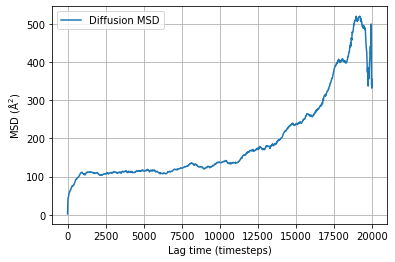

In [27]:
plt.plot(lag, msd, label="Diffusion MSD")
plt.xlabel("Lag time (timesteps)")
plt.ylabel("MSD ($\mathrm{Å}^2$)")
plt.legend()
plt.grid(True)
plt.show()

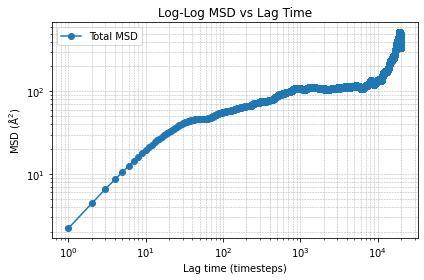

In [29]:
valid = msd > 0

plt.figure(figsize=(6, 4))
plt.loglog(lag[valid], msd[valid], marker='o', linestyle='-', label="Total MSD")
plt.xlabel("Lag time (timesteps)")
plt.ylabel("MSD ($\mathrm{Å}^2$)")
plt.title("Log-Log MSD vs Lag Time")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
def separate_and_stitch_trajectories(trj, ion_ids, jump_timesteps):
    """
    Splits trajectory into diffusive and jump contributions and stitches them into continuous paths.

    Parameters:
        trj: trajectory object with .trajectory (scaled) and .box_size (real units)
        ion_ids (np.ndarray): H3O+ particle ID at each timestep
        jump_timesteps (list of int): t where jump occurs between t and t+1

    Returns:
        diff_traj (np.ndarray): continuous trajectory of stitched diffusive chunks
        jump_traj (np.ndarray): stitched trajectory of jump steps only
    """
    trajectory = trj.trajectory
    box_size = trj.box_size
    T = len(trajectory)
    
    jump_timesteps = sorted(jump_timesteps)
    jump_set = set(jump_timesteps)

    # Identify all diffusion intervals: (start, end)
    intervals = []
    start = 0
    for jt in jump_timesteps:
        if start < jt:
            intervals.append((start, jt))  # [start, jt)
        start = jt + 1
    if start < T:
        intervals.append((start, T))  # final piece

    # Build diffusive trajectory
    diff_traj = []
    prev_end = None
    for (start, end) in intervals:
        segment = np.array([
            trajectory[t][ion_ids[t], 2:] * box_size[t]
            for t in range(start, end)
        ])
        if prev_end is not None:
            shift = prev_end - segment[0]
            segment += shift
        prev_end = segment[-1]
        diff_traj.append(segment)

    diff_traj = np.concatenate(diff_traj)

    # Build jump trajectory as displacement chain
    jump_traj = []
    pos = np.zeros(3)
    jump_traj.append(pos.copy())
    for jt in jump_timesteps:
        if jt+1 >= T:
            continue
        r1 = trajectory[jt][ion_ids[jt], 2:] * box_size[jt]
        r2 = trajectory[jt+1][ion_ids[jt+1], 2:] * box_size[jt+1]
        jump = r2 - r1
        pos += jump
        jump_traj.append(pos.copy())

    jump_traj = np.array(jump_traj)

    return diff_traj, jump_traj


def compute_msd_from_stitched_traj(traj_segment):
    """
    Compute MSD from a stitched real-space trajectory segment (e.g., diffusive or jump path).
    
    Parameters:
        traj_segment (np.ndarray): shape (T, 3), 3D coordinates in real space
    
    Returns:
        msd (np.ndarray): mean squared displacement values
        lags (np.ndarray): lag times (1, 2, ..., T-1)
    """
    n = len(traj_segment)
    msd = np.zeros(n - 1)
    lags = np.arange(1, n)

    for lag in lags:
        displacements = traj_segment[lag:] - traj_segment[:-lag]
        sq_dist = np.sum(displacements**2, axis=1)
        msd[lag - 1] = np.mean(sq_dist)

    return msd, lags

def plot_msd_dual(msd_diff, lags_diff, msd_jump, lags_jump, title="MSD Comparison"):
    """
    Plot MSD curves (diffusion and jump) in both linear and log-log representation.

    Parameters:
        msd_diff (np.ndarray): MSD values from diffusive trajectory
        lags_diff (np.ndarray): corresponding lag times for diffusion
        msd_jump (np.ndarray): MSD values from jumping trajectory
        lags_jump (np.ndarray): corresponding lag times for jumps
        title (str): plot title
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Linear plot
    axes[0].plot(lags_diff, msd_diff, label='Diffusive MSD', lw=2)
    axes[0].plot(lags_jump, msd_jump, label='Jump MSD', lw=2)
    axes[0].set_xlabel("Lag Time (timesteps)")
    axes[0].set_ylabel("MSD (units²)")
    axes[0].set_title("Linear Scale")
    axes[0].legend()
    axes[0].grid(True)

    # Log-log plot
    axes[1].loglog(lags_diff, msd_diff, label='Diffusive MSD', lw=2)
    axes[1].loglog(lags_jump, msd_jump, label='Jump MSD', lw=2)
    axes[1].set_xlabel("Lag Time (timesteps)")
    axes[1].set_ylabel("MSD (units²)")
    axes[1].set_title("Log-Log Scale")
    axes[1].legend()
    axes[1].grid(True, which="both", ls="--", lw=0.5)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [34]:
diff_trj, jump_trj = separate_and_stitch_trajectories(trj, h3o_ids_ts, jumps)

In [37]:
msd_diff, lag_diff = compute_msd_from_stitched_traj(diff_trj)
msd_jump, lag_jump = compute_msd_from_stitched_traj(jump_trj)

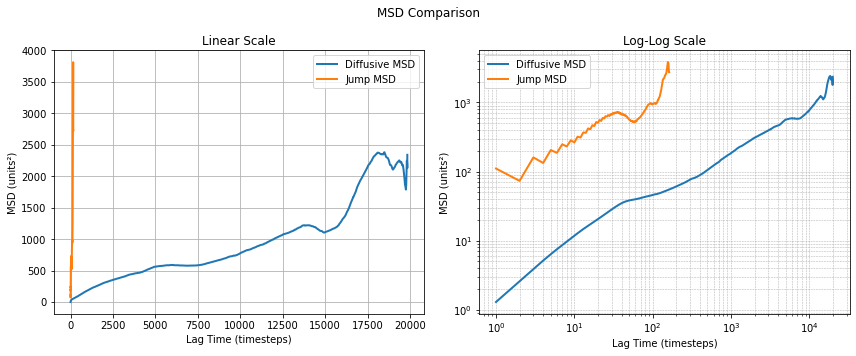

In [41]:
plot_msd_dual(msd_diff, lag_diff, msd_jump, lag_jump)

19838